In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pathlib import Path
import json
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('../')
from cxr_fairness.data import Constants
import matplotlib.lines as mlines
root_dir = Path('/scratch/hdd001/home/haoran/cxr_debias/') # dir of trained models, location of 'selected_configs.pkl'
fig_dir = Path('/scratch/ssd001/home/haoran/projects/CXR_Fairness/notebooks/cxr_debias_figures')
fig_dir.mkdir(exist_ok = True)

class smart_dict(dict):
    def __missing__(self, key):
        return key

grp_name_mapping = smart_dict({
    'F': "Female",
    'M': 'Male',
    0: 'White',
    1: 'Black',
    2: "Other"
})

orders = {
    'sex': ['M', 'F'],
    'ethnicity': [0, 1, 2],
    'age': ['18-40', '40-60', '60-80', '80-']    
}

In [2]:
config_df = pd.read_pickle(root_dir/'selected_configs.pkl')

In [3]:
task = 'no_finding'
dataset = 'MIMIC'

raws = []
path = Path(f'/ssd003/home/haoran/cxr_debias_boot/{dataset}_densenet_{task}_worst_roc_standard_boot.pkl') # bootstrap result path
df = pd.read_pickle(path)

In [4]:
df['dataset'] = path.name.split('_')[0]
df['model'] = path.name.split('_')[1]
raws.append(df)
df = pd.concat(raws, ignore_index= True)
df = df[df.grp_val != 'overall']

In [5]:
def map_metric(x):
    if x.startswith(('recall', 'specificity', 'precision', 'calibration_diff')):
        val = float(x.split('_')[-1])
        if val not in [0.75, 0.5, 0.25, 0.95, 0.05, 0.1]:
            return x[0].upper() + '_'.join(x.split('_')[:-1])[1:] + ' @ Opt'
        else:
            return x[0].upper() + '_'.join(x.split('_')[:-1])[1:] + ' @ ' + x.split('_')[-1]
    other_mapping = {
        'auc': 'AUROC',
        'auprc': 'AUPRC',
        'ace_abs_logistic_log': 'ACE',
        'loss_bce': 'BCE',
        'ece_abs': 'ECE'
    }
    return x if x not in other_mapping else other_mapping[x]

In [6]:
df.exp_name.unique()

array(['MMD', 'arl', 'balanced', 'dro', 'erm_baseline', 'fairalm', 'jtt',
       'mean_match', 'simple_adv', 'single_group'], dtype=object)

In [7]:
method_mapping = {
    'erm_baseline': 'ERM',
    'balanced': 'Balanced ERM',
    'single_group': 'Stratified ERM',
    'simple_adv': 'Adversarial',
    'MMD': 'MMDMatch',
    'mean_match': 'MeanMatch',
    'fairalm': 'FairALM',
    'dro': 'GroupDRO',
    'arl': 'ARL',
    'jtt': 'JTT'
}

In [8]:
df = df[df.exp_name.isin(list(method_mapping.keys()))]
df['exp_name'] = df['exp_name'].map(method_mapping)

In [9]:
df['metric'] = df['metric'].map(map_metric)

In [10]:
df.metric.unique()

array(['ACE', 'AUROC', 'AUPRC', 'ECE', 'BCE', 'mean_prediction',
       'mean_prediction_0', 'mean_prediction_1', 'Precision @ 0.1',
       'Precision @ 0.25', 'Precision @ Opt', 'Precision @ 0.5',
       'Precision @ 0.75', 'Recall @ 0.1', 'Recall @ 0.25',
       'Recall @ Opt', 'Recall @ 0.5', 'Recall @ 0.75',
       'sens_at_spec_0.1', 'sens_at_spec_0.2',
       'sens_at_spec_0.30000000000000004', 'sens_at_spec_0.4',
       'sens_at_spec_0.5', 'sens_at_spec_0.6',
       'sens_at_spec_0.7000000000000001', 'sens_at_spec_0.8',
       'sens_at_spec_0.9', 'Specificity @ 0.1', 'Specificity @ 0.25',
       'Specificity @ Opt', 'Specificity @ 0.5', 'Specificity @ 0.75'],
      dtype=object)

In [11]:
target = df.target.unique()[0]
df.target.unique()

array(['No Finding'], dtype=object)

In [12]:
df.dataset.unique()

array(['MIMIC'], dtype=object)

In [13]:
df.loc[df.metric == 'sens_at_spec_0.8', 'metric'] = 'TPR @ 80% TNR'
df.loc[df.metric == 'sens_at_spec_0.5', 'metric'] = 'TPR @ 50% TNR'

In [14]:
if task == 'no_finding':
    tpr_thres = '0.5'
    tnr_pct = '80'
else:
    tpr_thres = '0.1'
    tnr_pct = '50'

In [15]:
def make_plot(temp, figname, metrics = ['AUROC', 
                                  #       'AUPRC',  
                                 #        'ACE', 
                                        'BCE',
        'ECE', 
        f'TPR @ {tnr_pct}% TNR',
#         'TPR @ 50% TNR',
      #  'calibration_diff_0.5',
       f'Recall @ {tpr_thres}',
       f'Specificity @ {tpr_thres}',
#         'Recall @ 0.25',
#        'Specificity @ 0.25',
#        'Recall @ Opt',
#        'Specificity @ Opt',                                 
       ],
      plot_type = 'comparator'):
    
    assert(len(temp.target.unique()) == 1)
    attributes = ['sex', 'ethnicity', 'age']
    methods=list(reversed(list(method_mapping.values())))
    assert len(methods) <= len(temp.exp_name.unique())
    colors = ['C' + str(i) for i in reversed(range(len(methods)))]
    offsets = np.linspace(-0.25, 0.25, len(methods))
    
    fig, axs = plt.subplots(ncols = len(metrics), nrows = len(attributes), figsize = (20, 3*len(attributes)), sharex = 'col', dpi = 400)
    
    for d, t in enumerate(attributes):
        grps = list(reversed(orders[t]))
        grp_mapping = {
            i: c for c, i in enumerate(grps)
        }
            
        for c, m in enumerate(metrics):        
            ax = axs[d][c]    
            subset = temp[(temp.metric == m) & (temp.eval_group == t)]
            for e, method in enumerate(methods):
                subset2 = subset[subset.exp_name == method]
                if not len(subset2):
                    continue
                subset2['x'] = subset2['grp_val'].map(grp_mapping) + offsets[e]
                subset2 = subset2.sort_values(by = 'x', ascending = True)    
                subset2 = subset2[['CI_quantile_95' , plot_type, 'x']].pivot_table(values = plot_type, index = 'x', columns = 'CI_quantile_95', aggfunc = lambda x: x)
                subset2['lower_err'] = subset2['mid'] - subset2['lower']
                subset2['upper_err'] = subset2['upper'] - subset2['mid']
                yerrs = subset2[['lower_err', 'upper_err']].values.T
                
                ax.errorbar(y = subset2.index.values, x = subset2['mid'].values, fmt = '.', xerr = yerrs, color = colors[e])
                
            ax.set_yticks(range(len(grps)))            
            if c == 0:
                ax.set_ylabel(t)    
                ax.set_yticklabels([grp_name_mapping[g] for g in grps])
            else:
                ax.set_yticklabels([])           
            
            if d == 0:
                ax.set_title(m)
                
            if d == len(attributes) - 1:
                subset3 = temp[(temp.metric == m)]
                ax.set_xlim(right = subset3.loc[subset3.CI_quantile_95 == 'upper', plot_type].max() +0.05, 
                        left = subset3.loc[subset3.CI_quantile_95 == 'lower', plot_type].min() -0.05)
                
                ax.grid(which='both', axis = 'x', linestyle='--')
                for e in range(0, d):
                    axs[e][c].grid(which='both', axis = 'x', linestyle='--')

    # make custom legend
    legend = [
        mlines.Line2D([], [], linestyle = '-', color = colors[c], marker ='.',
                     label = method) for c, method in reversed(list(zip(range(len(methods)), methods)))
    ]

    # fig.subplots_adjust(right=0.9)
    leg1 = axs[0][-1].legend(handles = legend, loc='center left', bbox_to_anchor=(1.1,-0.7))  
    fig.savefig(fig_dir/(figname+ '.pdf'), dpi = 400, bbox_inches = 'tight')

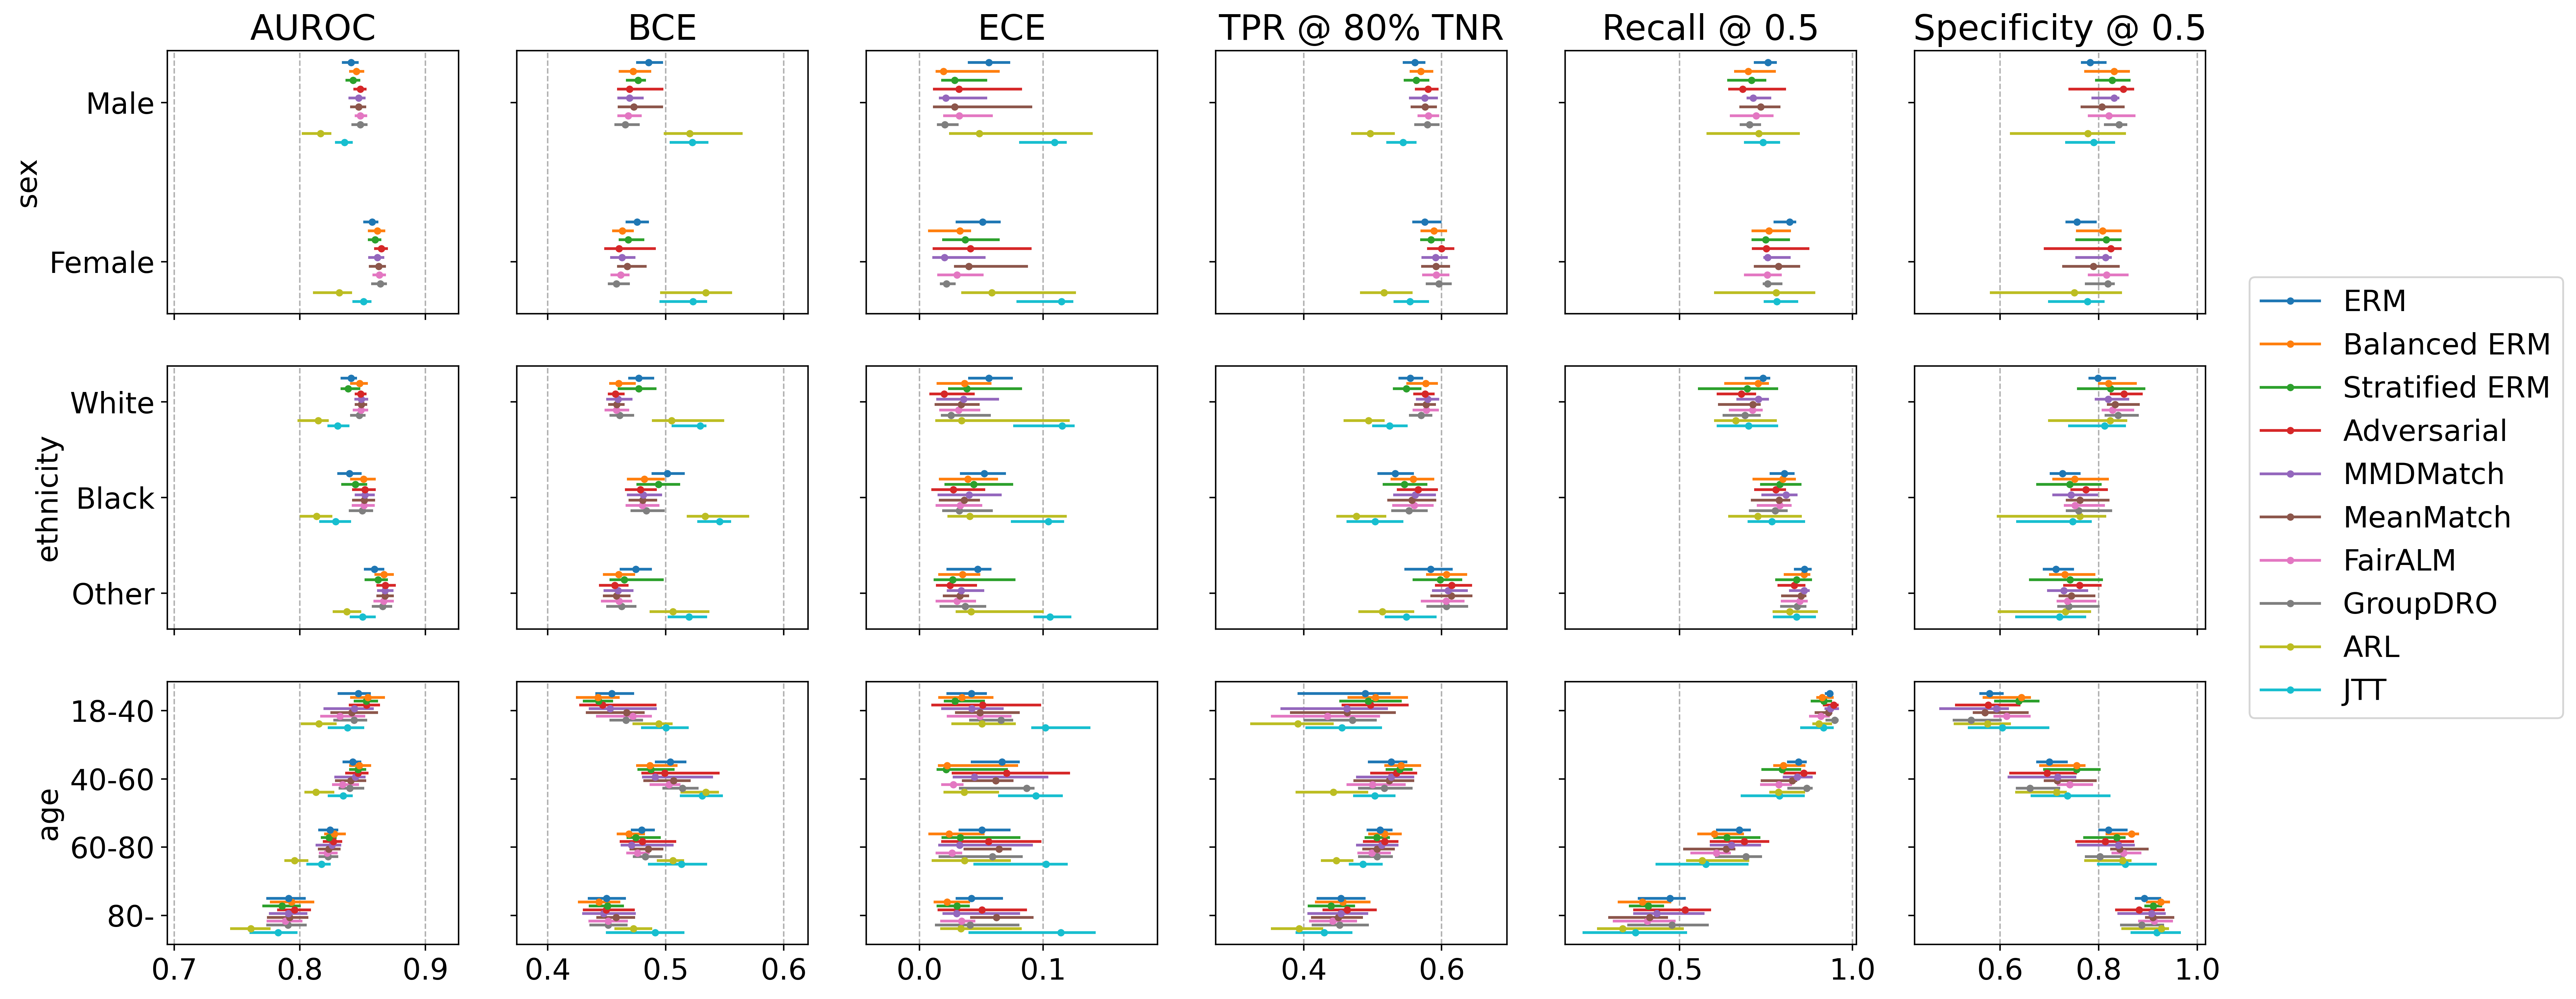

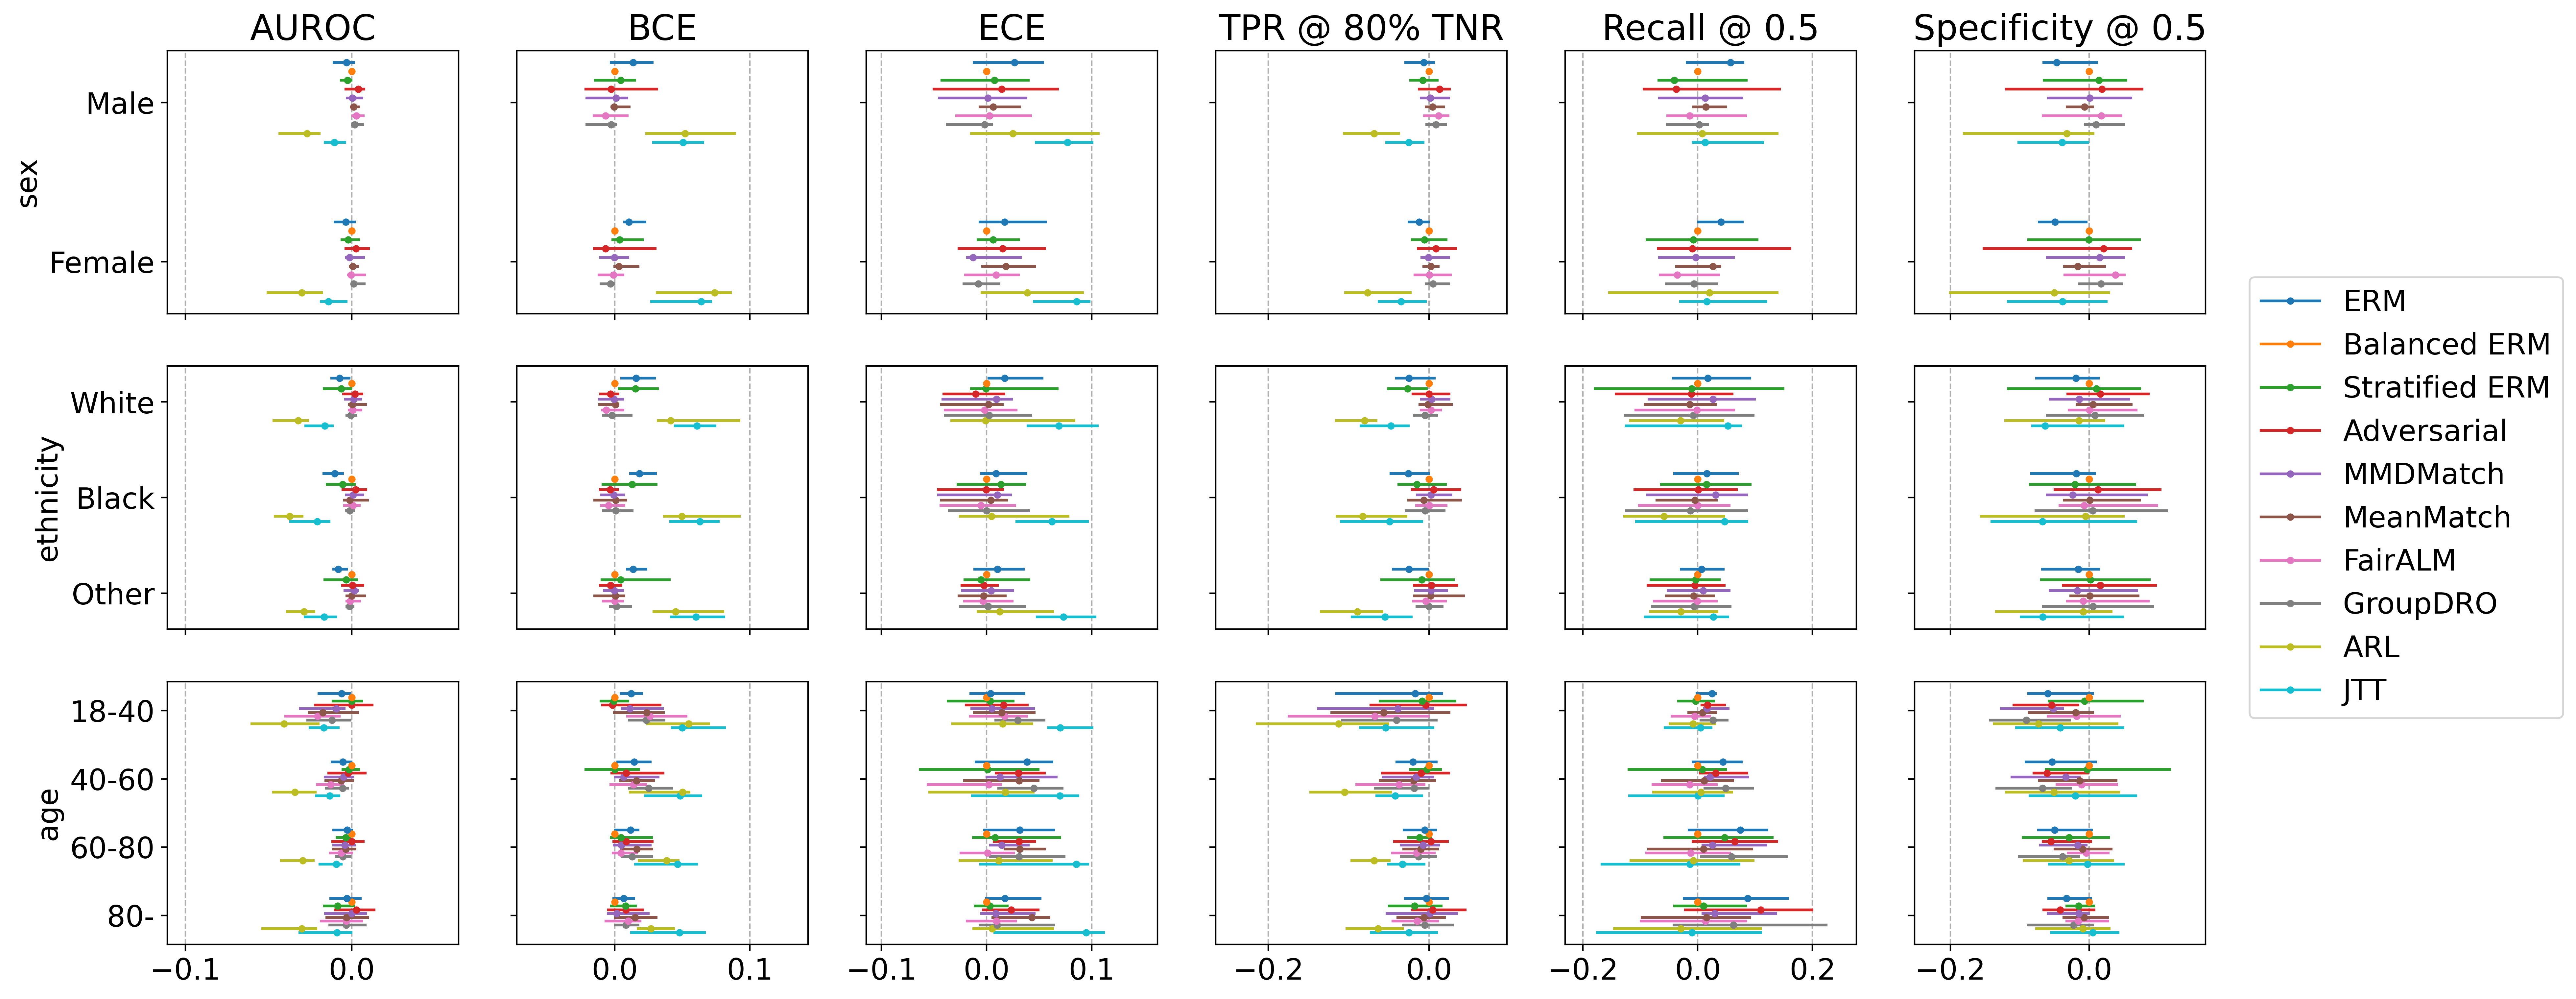

In [16]:
plt.rcParams['font.size'] = '16'

for plot_type in ['comparator', 'delta']:
    for dataset in df.dataset.unique():
        for model in df.model.unique():
            temp = df[(df.model == model) & (df.dataset == dataset)]
            if len(temp):
                make_plot(temp, f'{dataset}_{model}_{plot_type}_{target}', plot_type = plot_type)

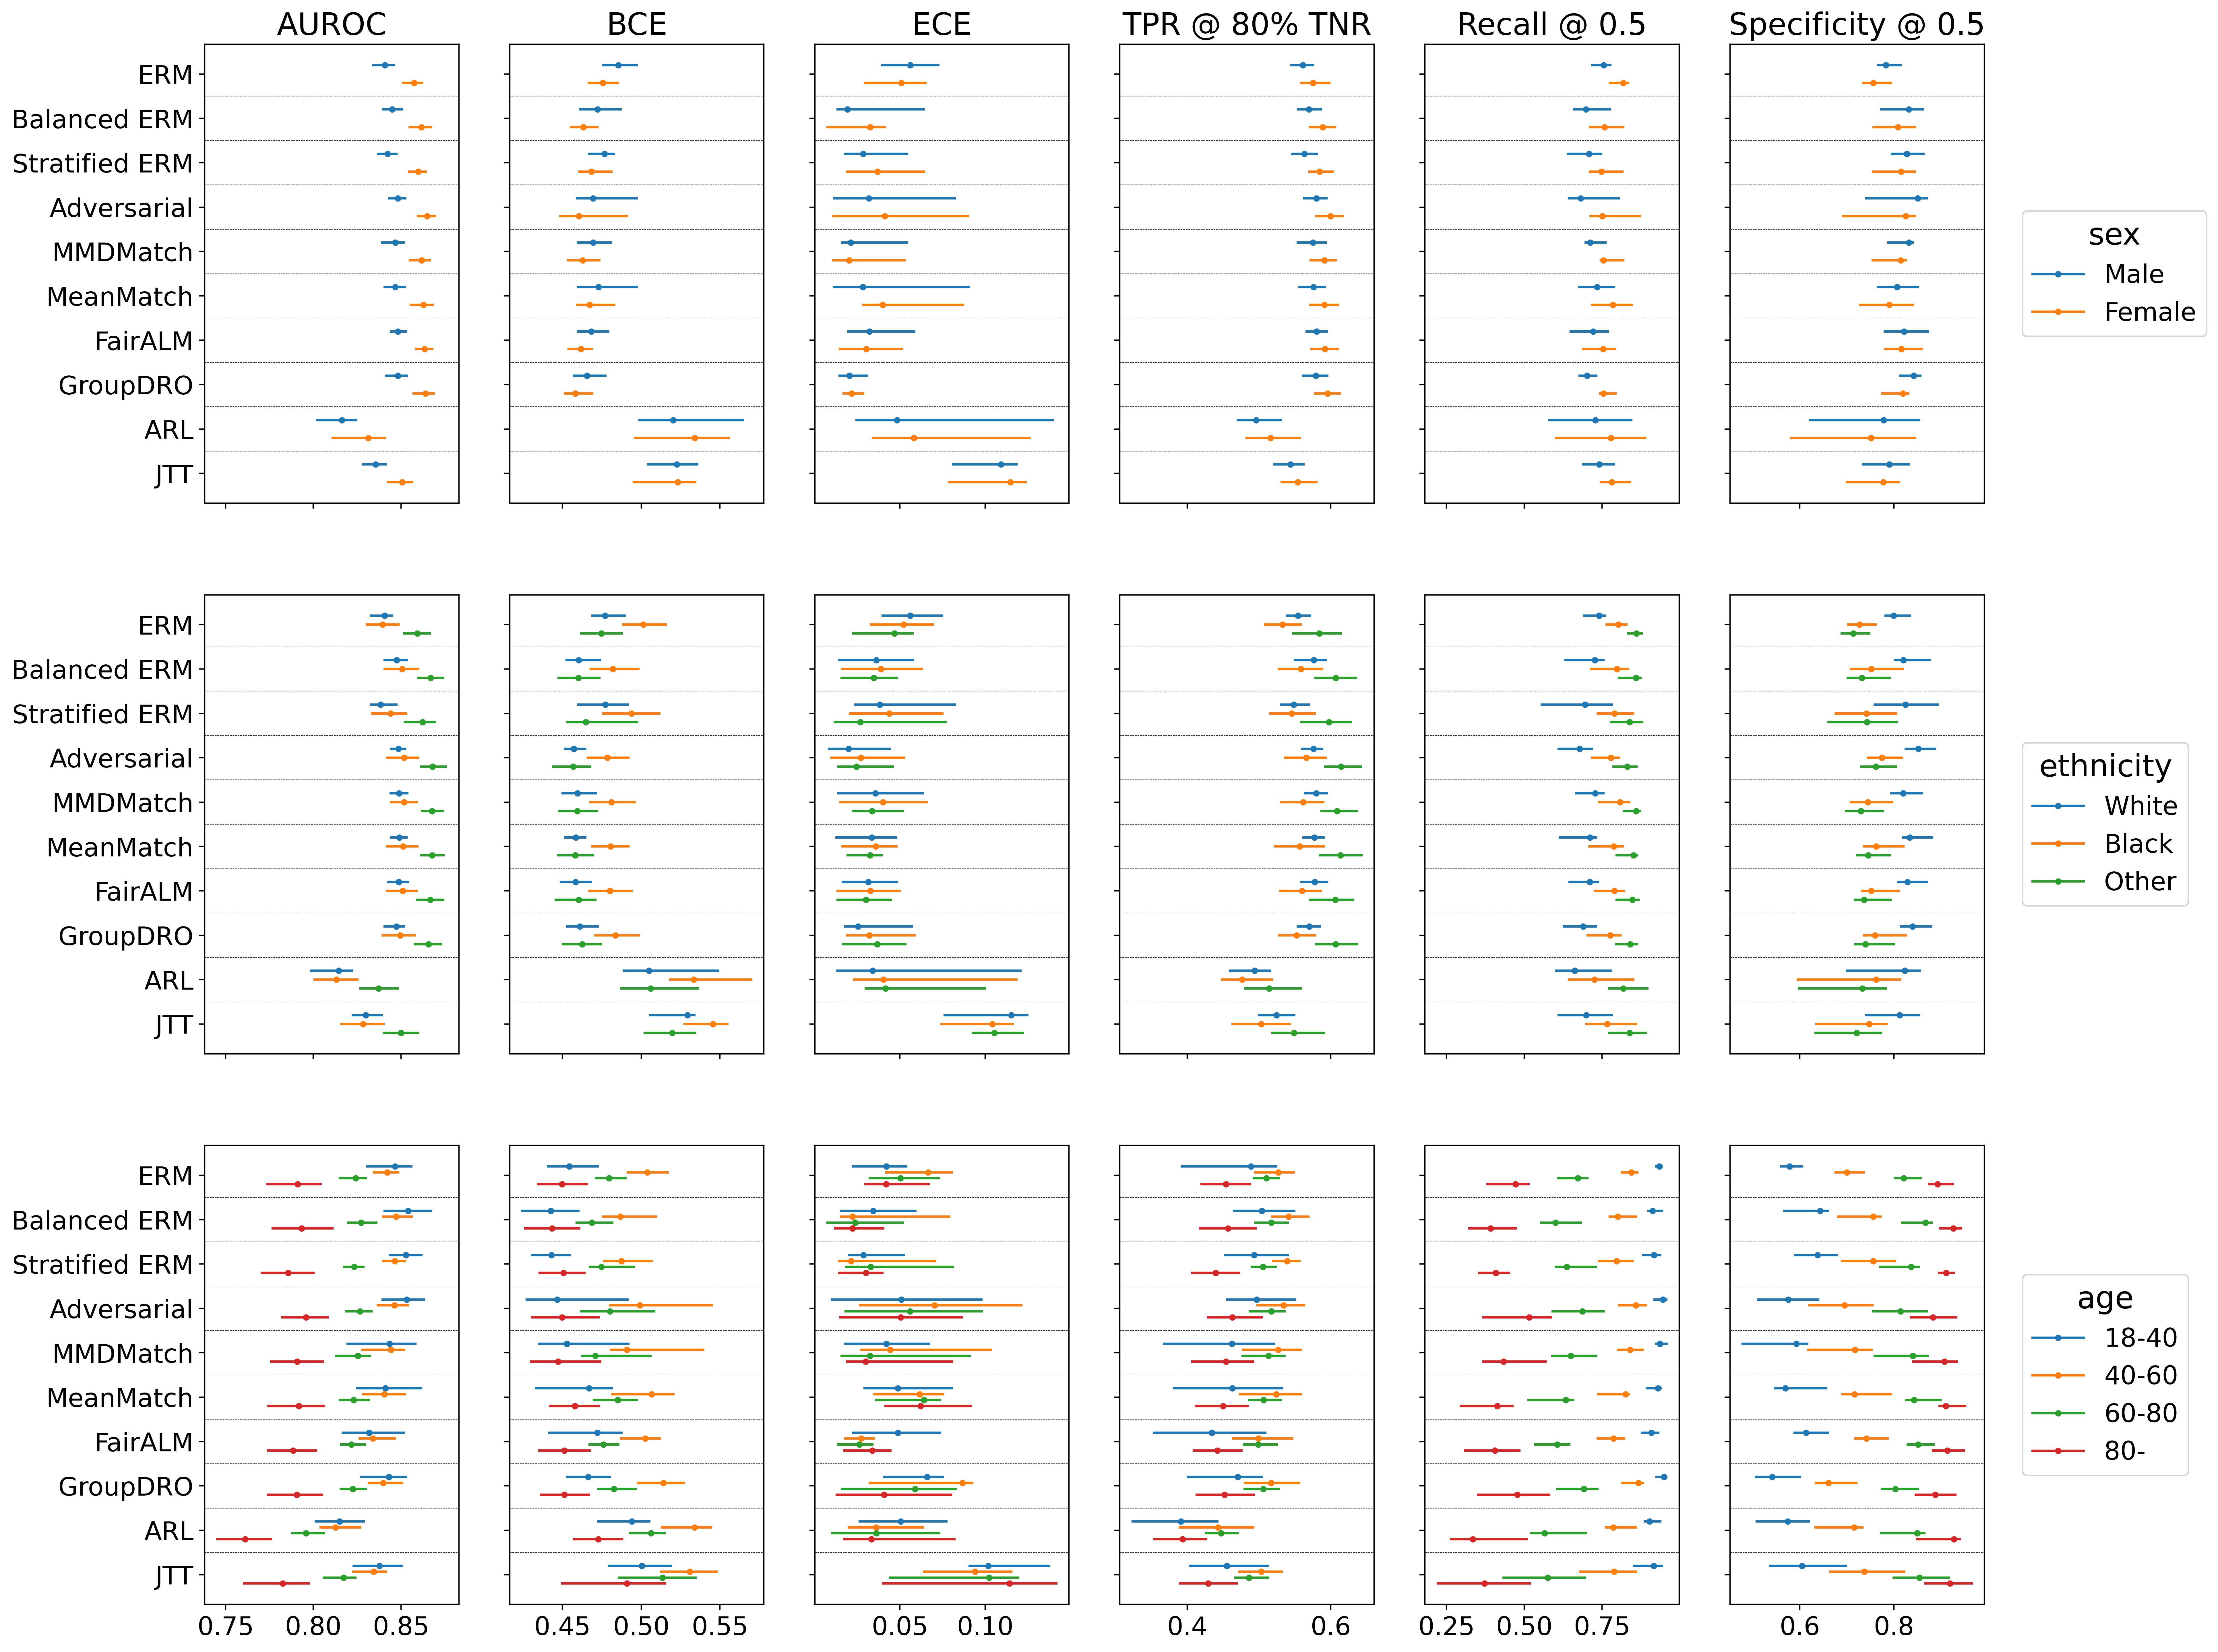

In [17]:
## alternative pivot
temp = df
plot_type = 'comparator'
metrics = ['AUROC', 
                                  #       'AUPRC',  
                                 #        'ACE', 
                                        'BCE',
        'ECE', 
     f'TPR @ {tnr_pct}% TNR',
#         'TPR @ 50% TNR',
      #  'calibration_diff_0.5',
       f'Recall @ {tpr_thres}',
       f'Specificity @ {tpr_thres}',
#         'Recall @ 0.25',
#        'Specificity @ 0.25',
#        'Recall @ Opt',
#        'Specificity @ Opt',                                 
       ]
    
assert(len(temp.target.unique()) == 1)
attributes = ['sex', 'ethnicity', 'age']
methods=list(reversed(list(method_mapping.values())))
assert len(methods) <= len(temp.exp_name.unique())
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

fig, axs = plt.subplots(ncols = len(metrics), nrows = len(attributes), figsize = (20, 6*len(attributes)), sharex = 'col', dpi = 400)

for d, t in enumerate(attributes):
    grps = list(orders[t])
    method_mapping_int = {
        i: c for c, i in enumerate(methods)
    }
    
    offsets = np.flip(np.linspace(-0.2, 0.2, len(grps)))

    for c, m in enumerate(metrics):        
        ax = axs[d][c]    
        subset = temp[(temp.metric == m) & (temp.eval_group == t)]
        for e, grp in enumerate(grps):
            subset2 = subset[subset['grp_val'] == grp]
            if not len(subset2):
                continue
            subset2['x'] = subset2['exp_name'].map(method_mapping_int) + offsets[e]
            subset2 = subset2.sort_values(by = 'x', ascending = True)    
            subset2 = subset2[['CI_quantile_95' ,plot_type, 'x']].pivot_table(values = plot_type, index = 'x', columns = 'CI_quantile_95', aggfunc = lambda x: x)
            subset2['lower_err'] = subset2['mid'] - subset2['lower']
            subset2['upper_err'] = subset2['upper'] - subset2['mid']
            yerrs = subset2[['lower_err', 'upper_err']].values.T

            ax.errorbar(y = subset2.index.values, x = subset2['mid'].values, fmt = '.', xerr = yerrs, color = colors[e])

        ax.set_yticks(range(len(methods)))            
        if c == 0:
            ax.set_yticklabels(methods)
        else:
            ax.set_yticklabels([])           

        if d == 0:
            ax.set_title(m)
        
        for f in np.arange(0, len(methods) - 1):
            ax.axhline(f + 0.5, linestyle='--', color='k', linewidth = 0.3)
            
    legend = [
        mlines.Line2D([], [], linestyle = '-', color = colors[c], marker ='.',
                     label = grp_name_mapping[grp]) for c, grp in list(zip(range(len(grps)), grps))
    ]

    leg1 = axs[d][-1].legend(handles = legend, loc='center left', bbox_to_anchor=(1.1, 0.5))  
    leg1.set_title(t, prop = {'size': 'large'})

fig.savefig(fig_dir/f'{dataset}_compr_{target}_alternate.pdf', dpi = 400, bbox_inches = 'tight')